# Numerical experiements for the hypercube
This document reproduces the results of the paper for a hypercube.

## 1. Imports

In [1]:
# Maths
import numpy as np
import math 
from math import pi 
# Plot
import matplotlib.pyplot as plt
import seaborn as sns
# Graph
import networkx as nx 
# Utilities
import copy
from tqdm.notebook import tqdm
import pandas as pd
import sys
# Fit
from sklearn.linear_model import LinearRegression
# Parallelisation
from multiprocessing import Pool

# QWSearch
from qwgraph import QWSearch,coins,PipeLine,AddressingType,pipelines

# Plot configuration
sns.set()
sns.set_context("poster")
sns.set_style("ticks")

idc = lambda x : np.array(list(range(len(x))))

## 2. Signal of a search
We search one node in the hypercube according to the procedure explained in the paper.
 1. Generate a hypercube
 2. Starify it
 3. Mark the right virtual edge
 4. Search with the QW

Text(0, 0.5, 'probability of success')

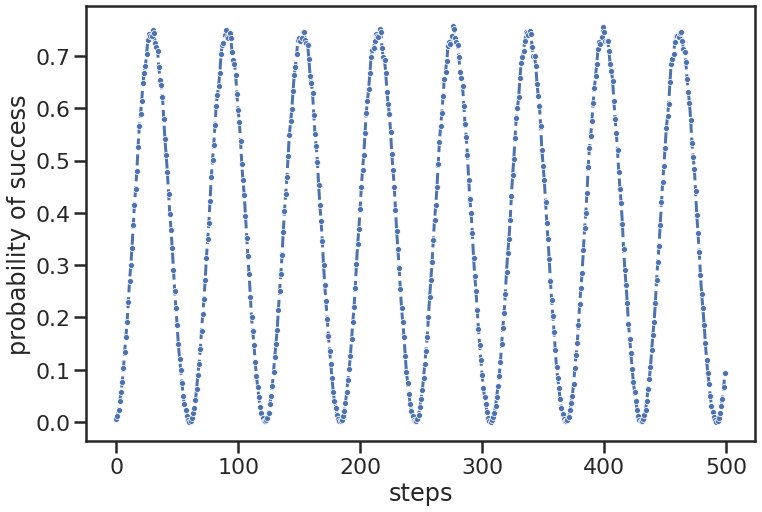

In [2]:
G = nx.convert_node_labels_to_integers(G = nx.hypercube_graph(7)) # Initial graph : hypercube of dimension 7
qw = QWSearch(G, starify=True) # Generation of the QW
searched = [0]
p = qw.run(pipelines.search_virtual_edges(coins.X, "grover", searched, -coins.X), ticks=500) # The signal of the walk

plt.figure(figsize=(12,8))
sns.lineplot(x=idc(p),y=p,marker='.', linestyle='--')
plt.xlabel("steps")
plt.ylabel("probability of success")

## 3. Hitting time and probability of success
We will now compute the hitting time $T$ and the probability of success $P$ for different grid sizes.
The algorithm used to compute the hitting time is as follow:
 1. Set S = [p(0)]
 2. Compute the 30 first steps of the signal S : S = [p(0),...,p(30)]
 3. Set a = argmin(S) and b = argmax(S)
 4. If S[-1] > $\frac{a+b}{2}$ then return (T=b, P=S[b])
 5. Else, compute next step and go back to step 4.

The full code for this can be found in ./pqwfast.py -> fn carac

In [3]:
def lin_fit(x,y):
    X = np.array([[i] for i in x])
    reg = LinearRegression().fit(X, y)
    text = "score : {:.5f}\nintercept : {:.5f}\ncoef : {:.5f}\n".format(reg.score(X,y),reg.intercept_,reg.coef_[0])
    print(text)
    return reg.predict(X), text

In [4]:
def get_T_P(n):
    """
    Parameter:
        n -> dimension of the hypercube
    Return:
        pandas dataframe with a lot of informations on the search.
    """
    G = nx.convert_node_labels_to_integers(G = nx.hypercube_graph(n))
    qw = QWSearch(G, starify=True) # Generation of the QW
    searched = [0]
    T,P = qw.get_T_P(pipelines.search_virtual_edges(coins.X, "grover", searched, -coins.X),waiting=30)
    dic = {"$N$":len(list(G.nodes())), "$M$":len(list(G.edges())), "$\\tilde N$":len(list(qw.nodes())), "$\\tilde M$":len(list(qw.edges())),
            "degree_centrality $G$":nx.degree_centrality(G)[0], "degree_centrality $\\tilde G$":nx.degree_centrality(qw.graph())[0], "$T$":T, "$P$":P,}
    return pd.DataFrame({i : [dic[i]] for i in dic})

get_T_P(7)

,$N$,$M$,$\tilde N$,$\tilde M$,degree_centrality $G$,degree_centrality $\tilde G$,$T$,$P$
0,128,448,256,576,0.055118,0.031373,31,0.749786


In [5]:
# This cell compute data for a lot of grid size (might take a while).
graph_sizes = list(range(4,16,1))
np.random.shuffle(graph_sizes)
with Pool(16) as p:
    data = pd.concat(list(tqdm(p.imap_unordered(get_T_P,graph_sizes), total=len(graph_sizes), desc="Computing hitting time and probability of success for various graph sizes")))

Computing hitting time and probability of success for various graph sizes:   0%|          | 0/12 [00:00<?, ?it…

### 3.1 Hitting time

score : 0.99989
intercept : 2.09068
coef : 1.18869



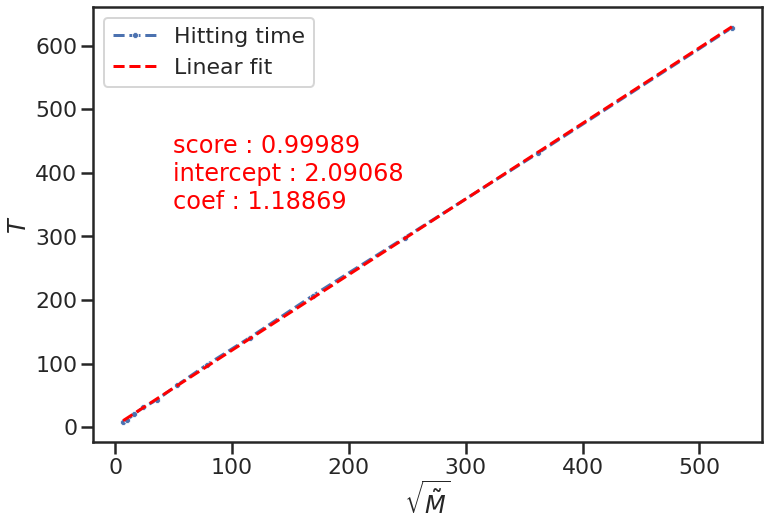

In [6]:
x = np.sqrt(data["$\\tilde M$"])
y = np.array(list(data["$T$"]))
z, text = lin_fit(x,y)

plt.figure(figsize=(12,8))
sns.lineplot(x=x,y=y,marker='.', linestyle='--', label="Hitting time")
sns.lineplot(x=x,y=z, linestyle='--', color="red", label="Linear fit")
plt.annotate(text, xy=(50, 300),color="red")
plt.xlabel("$\\sqrt{\\tilde M}$")
plt.ylabel("$T$")
plt.savefig("img/hypercube_T.png", bbox_inches='tight')

score : 0.99980
intercept : 4.22489
coef : 1.07318



Text(0, 0.5, '$T$')

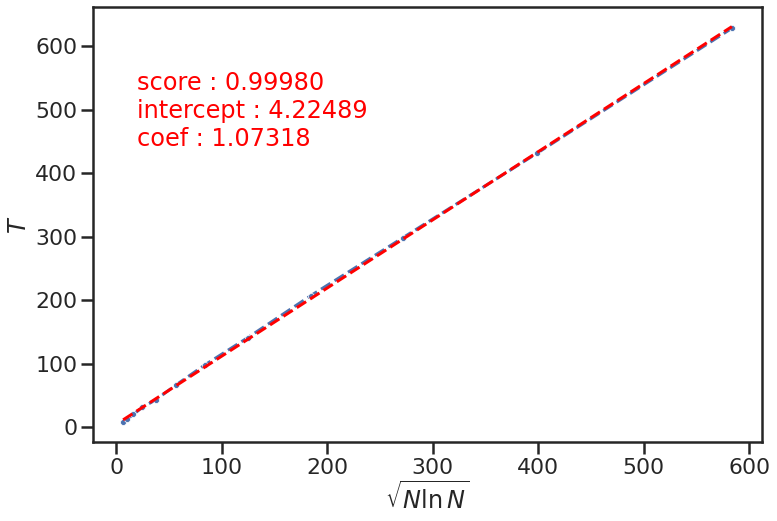

In [7]:
x = np.array(list(data["$N$"]))
y = np.array(list(data["$T$"]))
x = np.sqrt(x*np.log(x))
z, text = lin_fit(x,y)

plt.figure(figsize=(12,8))
sns.lineplot(x=x,y=y,marker='.', linestyle='--')
sns.lineplot(x=x,y=z, linestyle='--', color="red")
plt.annotate(text, xy=(20, 400),color="red")
plt.xlabel("$\\sqrt{N\ln N}$")
plt.ylabel("$T$")

### 3.2 Probability of success

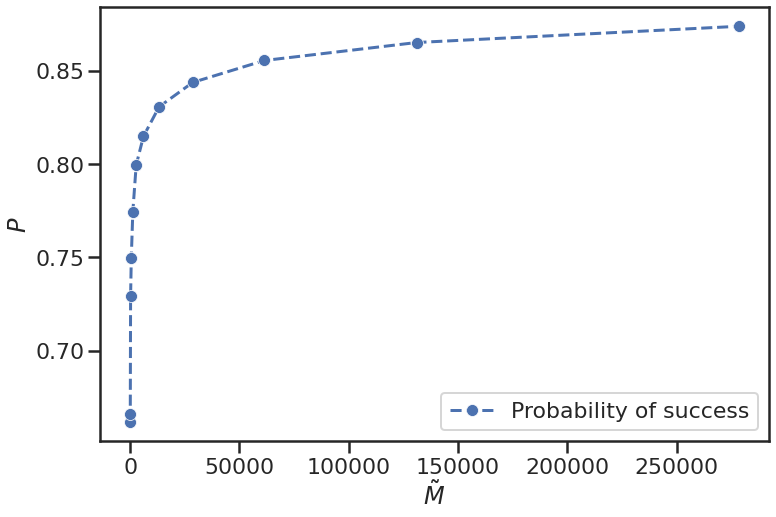

In [8]:
x = np.array(list(data["$\\tilde M$"]))
y = np.array(list(data["$P$"]))
x = x
#z, text = lin_fit(x[2:],y[2:])

plt.figure(figsize=(12,8))
sns.lineplot(x=x,y=y,marker='o', linestyle='--', label="Probability of success")
#sns.lineplot(x=x[2:],y=z, linestyle='--', color="red")
#plt.annotate(text, xy=(1.5, 0.77),color="red")
plt.xlabel("$\\tilde M$")
plt.ylabel("$P$")
plt.savefig("img/hypercube_P.png", bbox_inches='tight')

score : 0.99627
intercept : 0.49793
coef : 0.16233



Text(0, 0.5, '$P$')

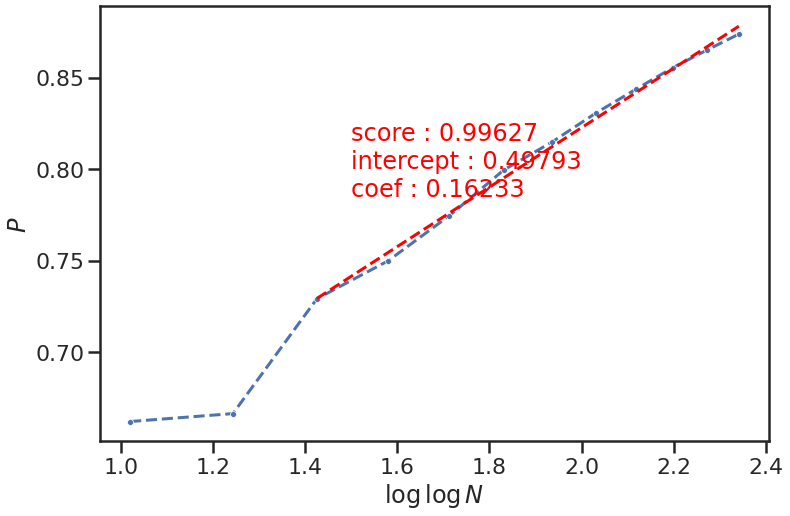

In [9]:
x = np.array(list(data["$N$"]))
y = np.array(list(data["$P$"]))
x = np.log(np.log(x))
z, text = lin_fit(x[2:],y[2:])

plt.figure(figsize=(12,8))
sns.lineplot(x=x,y=y,marker='.', linestyle='--')
sns.lineplot(x=x[2:],y=z, linestyle='--', color="red")
plt.annotate(text, xy=(1.5, 0.77),color="red")
plt.xlabel("$\\log \\log N$")
plt.ylabel("$P$")
#plt.xscale("log")